In [39]:
# -*- coding: utf-8 -*-
#  Copyright 2021 - 2024 United Kingdom Research and Innovation
#  Copyright 2021 - 2024 The University of Manchester
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Mariam Demir (UKRI-STFC)

### Load and Visualise Data Using TIFFStackReader
##### This example shows how to use the `TIFFStackReader` to load data from .tiff files and quickly visualise the data and geometry

In [1]:
from cil.io import TIFFStackReader
from cil.framework import AcquisitionGeometry, AcquisitionData
from cil.utilities import dataexample
from cil.utilities.display import show_geometry
from cil.utilities.display import show2D
import numpy as np
import os

Get the example dataset `dataexample.SANDSTONE` using `download_data()`.

In [2]:
dataexample.SANDSTONE.download_data(data_dir='../data', prompt=False)

Title: Synchrotron X-ray tomography data of sandstone (sample BBii)
Keywords: 
Publication date: 2021-06-08
DOI: 10.5281/zenodo.4912435
Total size: 207.3 MB

Link: https://zenodo.org/records/4912435/files/small.zip   size: 207.3 MB

Checksum is correct. (1037af92cdbb0a831fa5609e2696f971)
All files have been downloaded.


True

Now we can load the .tif file from the dataset using the `TIFFStackReader`  
The reader can take a directory or a list of .tiff or .tif files as an argument.  
Here, we create a list of the .tif files, excluding the dark- and flat-field files (See the `FlatDarkFieldNormaliser` notebook for more information). 

We specify the files to load using `file_name = tiff_files`

In [3]:
data_dir = '../data/sandstone/proj'
tiff_files = [os.path.join(data_dir, file) for file in os.listdir(data_dir) if ".tif" in file \
              and (file not in ["BBii_0001.tif", "BBii_0002.tif", "BBii_0031.tif", \
                                "BBii_0032.tif", "BBii_1632.tif", "BBii_1633.tif"])]

data_reader = TIFFStackReader(file_name=tiff_files)
data = data_reader.read()

print(data.shape)

(8, 2160, 2560)


We can see the data contains 8 projections, with 2160 vertical and 2560 horizontal pixels. The projections are taken over 0-180 degrees.  
To use CIL's visualisation and reconstruction tools, we need to store this array in an `AcquisitionData` object - This object holds the pixel data, and the `AcquisitionGeometry`.

First, we will manually create the `AcquisitionGeometry` object based on information about the experimental setup.

This dataset has parallel-beam geometry, so we create a Parallel3D `AcquisitionGeometry` object:
* We know the first axis is angle, the second is vertical, and the third is horizontal, so we set `dimension_labels` to `('angle', 'vertical', 'horizontal')`  

* We set the `num_pixels` to a tuple containing the number of horizontal and vertical pixels, `(data.shape[2], data.shape[1])`.  

* The `angles` are set to an array of the projection angles.

In [4]:
parallel_geom = AcquisitionGeometry.create_Parallel3D()  \
         .set_labels(['angle', 'vertical', 'horizontal']) \
         .set_panel(num_pixels=(data.shape[2], data.shape[1]))        \
         .set_angles(angles=np.linspace(0,180,8,endpoint=False))

Check the geometry shape, and source/detector positions look accurate using `show_geometry()`:

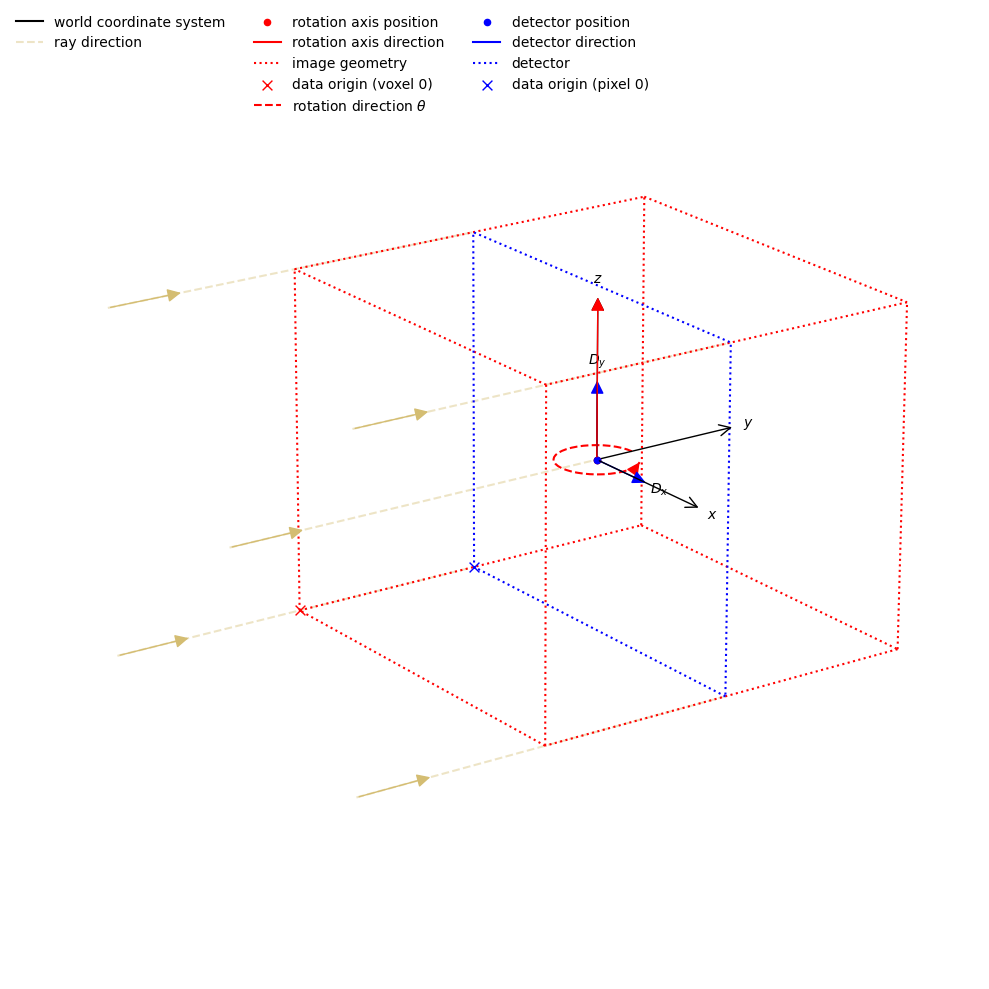

In [5]:
show_geometry(parallel_geom)

Finally, we use the loaded data and `AcquisitionGeometry` to create the `AcquisitionData` object:

In [6]:
sandstone = AcquisitionData(array=data, geometry=parallel_geom)
print(sandstone)

Number of dimensions: 3
Shape: (8, 2160, 2560)
Axis labels: (<AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)



Now the data has been loaded, and we are able to use CIL's visualisation and reconstruction tools on the dataset.  
We can view a central projection of the data with `show2D()`:

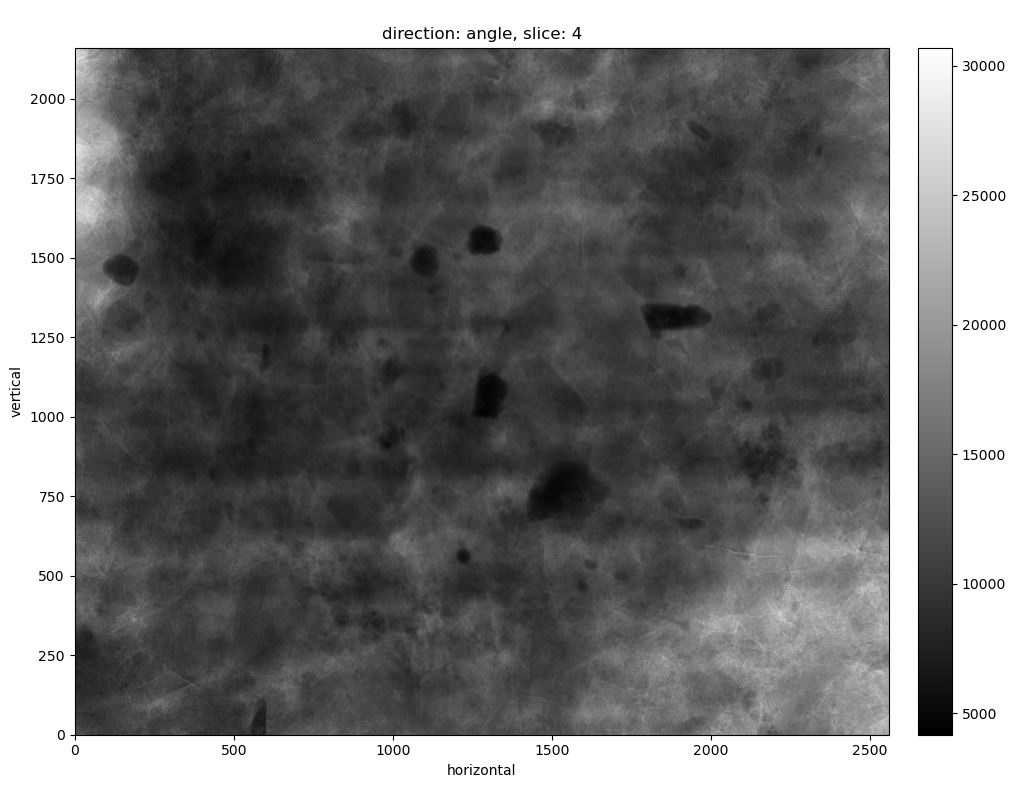

In [7]:
show2D(sandstone)

In [8]:
%store sandstone

Stored 'sandstone' (AcquisitionData)


#### Using TIFFStackReader's Additional Arguments:

Use the `roi` argument when reading the file to load a subset of the data. `roi` should be passed as a dictionary  
e.g. `{'axis_1': (start, end, step), 'axis_2': (start, end, step)}` with axis labels `'axis_0'` (angle), `'axis_1'` (vertical), or `'axis_2'` (horizontal)

To load a cropped subset of the data, change the start and end values. 'axis_label': -1 is a shortcut to load all elements along the axis.

In [9]:
roi = {'axis_1':(100, 800, 1), 'axis_2':(-1)}
data_reader = TIFFStackReader(file_name=tiff_files, roi=roi)
data = data_reader.read()

Update the `AcquisitionGeometry` to the roi data's pixel numbers and create the updated `AcquisitionData`:

Number of dimensions: 3
Shape: (8, 700, 2560)
Axis labels: (<AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)



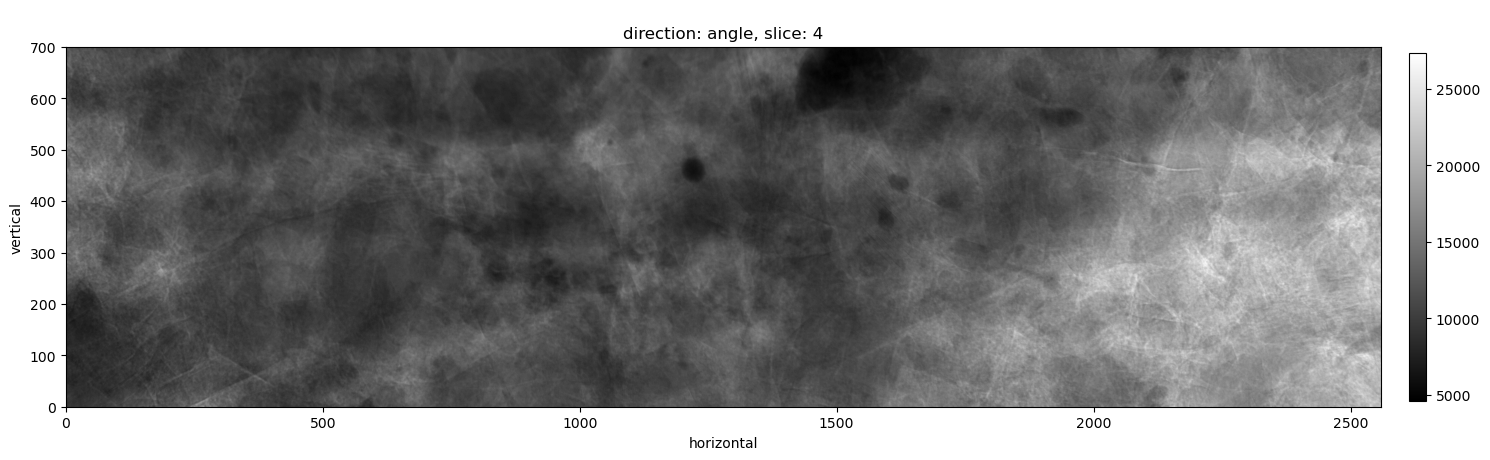

In [10]:
parallel_geom.set_panel(num_pixels=(data.shape[2], data.shape[1]))
sandstone = AcquisitionData(array=data, geometry=parallel_geom)

print(sandstone)
show2D(sandstone)

To load a binned subset of the data, change the step value. 
Here we use different binning for the vertical (`axis_1`) and horizontal (`axis_2`) dimensions, which results in a different aspect ratio:

Number of dimensions: 3
Shape: (8, 1080, 640)
Axis labels: (<AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)



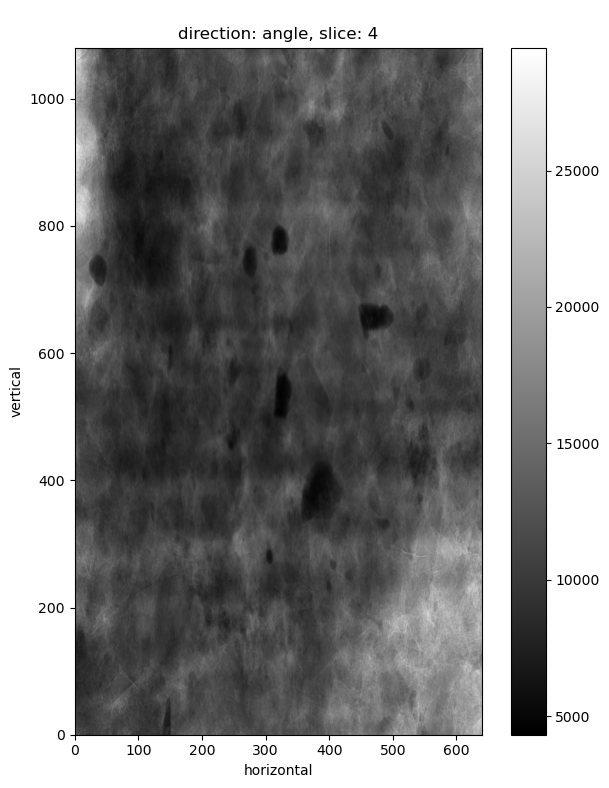

In [11]:
roi = {'axis_1':(None, None, 2), 'axis_2':(None, None, 4)}
data_reader = TIFFStackReader(file_name=tiff_files, roi=roi)
data = data_reader.read()

parallel_geom.set_panel(num_pixels=(data.shape[2], data.shape[1]))
sandstone = AcquisitionData(array=data, geometry=parallel_geom)

print(sandstone)
show2D(sandstone)